# **Segmenting and Clustering Neighborhoods in Toronto**

#### Install lxml pacakge to read HTML links

In [3]:
pip install lxml

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install bs4

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install geopy

Note: you may need to restart the kernel to use updated packages.


### Import libraraies

In [6]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup as bs
import requests as req
import re
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium # map rendering library

### Read link with read_html function and use BeautifulSoup and request libraries to get the Data

In [7]:
pd.set_option('display.max_rows', 100)
url=('https://www.google.com/search?sxsrf=ALeKk00dGmynIfHYQ8zz8ceFxzcQA6saTQ:1588266993851&q=ottawa+neighbourhoods&sa=X&ved=2ahUKEwjv9ufP05DpAhU4DmMBHck-AFYQ7xYoAHoFCB4QxAE&biw=1536&bih=700')
response=req.get(url)
ottawa_data=bs(response.text, 'lxml')
contents=ottawa_data.find_all('div', class_='RWuggc kCrYT')
columns=['Neighborhood']
ottawa_neighborhood=pd.DataFrame(columns = columns)
for content in contents:
    neighbor=content.find('div').find('div').text
    ottawa_neighborhood=ottawa_neighborhood.append({'Neighborhood': neighbor}, ignore_index=True)
ottawa_neighborhood.head(6)

,Neighborhood
0,Orléans
1,Downtown
2,Barrhaven
3,ByWard Market
4,Stittsville
5,Manotick


### Save the data to CSV file

In [8]:
ottawa_neighborhood.to_csv("Ottawa.csv")

### Get geographical coordinates of neighborhoods

In [9]:
# location=geolocator.geocode(ottawa_coord,timeout=10000)
ottawa_coord=pd.DataFrame(columns=['Latitude','Longitude'])
geolocator=Nominatim(user_agent="Ottawa")
for row in ottawa_neighborhood['Neighborhood']:
    location=geolocator.geocode(row)
    ottawa_coord=ottawa_coord.append({'Latitude':location.latitude, 'Longitude':location.longitude}, ignore_index=True)
ottawa_neighborhood=ottawa_neighborhood.join(ottawa_coord)
ottawa_neighborhood.head()

,Neighborhood,Latitude,Longitude
0,Orléans,45.481032,-75.510000
1,Downtown,34.042849,-118.247673
2,Barrhaven,45.265225,-75.765974
3,ByWard Market,45.427917,-75.692601
4,Stittsville,45.269066,-75.914523


### Create Ottawa map with neighborhoods using folium library

In [10]:
address = 'Ottawa'

geolocator = Nominatim(user_agent="Ottawa")
location = geolocator.geocode(address)
latitude_ottawa = location.latitude
longitude_ottawa = location.longitude
map_ottawa = folium.Map(location=[latitude_ottawa, longitude_ottawa], zoom_start=8)

# add markers to map
for lat, lng, postal in zip(ottawa_neighborhood['Latitude'],ottawa_neighborhood['Longitude'],ottawa_neighborhood['Neighborhood']):
    label = str(postal)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [float(lat), float(lng)],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ottawa)  
    
map_ottawa

### Foursquare credentials

In [11]:
#@hidden_cell
CLIENT_ID='H5UBRE3IT2DJA3EEOJ0N5HXMJOWQYCTDP5VMFFEWXVV1EKAJ'
#@hidden_cell
CLIENT_SECRET='5MBXVM1W35GTZFCVNJNX0PAFKDJDNWER51RW3P4PY4NPSAVN'
#@hidden_cell
VERSION = '20180605'

### Load Venues and Analyze Neighborhoods in Ottawa using foursquare

In [12]:
radius=1000
LIMIT=100
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = req.get(url).json()["response"]['groups'][0]['items']
        print(results)
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)
ottawa_venues = getNearbyVenues(names=ottawa_neighborhood['Neighborhood'],
                                   latitudes=ottawa_neighborhood['Latitude'],
                                   longitudes=ottawa_neighborhood['Longitude'])

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4b06a890f964a52043ee22e3', 'name': 'Shenkman Arts Centre / Centre des Arts Shenkman', 'location': {'address': '245 Centrum Blvd', 'crossStreet': "Place d'Orleans Dr.", 'lat': 45.48035243398533, 'lng': -75.51115288839266, 'labeledLatLngs': [{'label': 'display', 'lat': 45.48035243398533, 'lng': -75.51115288839266}], 'distance': 117, 'postalCode': 'K1E 0A1', 'cc': 'CA', 'city': 'Ottawa', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ["245 Centrum Blvd (Place d'Orleans Dr.)", 'Ottawa ON K1E 0A1', 'Canada']}, 'categories': [{'id': '5032792091d4c4b30a586d5c', 'name': 'Concert Hall', 'pluralName': 'Concert Halls', 'shortName': 'Concert Hall', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/musicvenue_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4b06a8

In [35]:
print('# There are {} unique venue categories. Some of them are as below:'.format(len(ottawa_venues['Venue Category'].unique())))
ottawa_venues.head()

# There are 177 unique venue categories. Some of them are as below:


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Orléans,45.481032,-75.51,Shenkman Arts Centre / Centre des Arts Shenkman,45.480352,-75.511153,Concert Hall
1,Orléans,45.481032,-75.51,St. Martha's Brasserie d'Orléans,45.480228,-75.509322,French Restaurant
2,Orléans,45.481032,-75.51,Farm Boy,45.477637,-75.513385,Grocery Store
3,Orléans,45.481032,-75.51,Ruddy Family YMCA-YWCA,45.481075,-75.509561,Gym
4,Orléans,45.481032,-75.51,D'Arcy McGee's Orleans,45.480339,-75.509677,Irish Pub


In [34]:
print('# Top 10 distinct venue counts are as below')
ottawa_venues[['Venue','Venue Category']].drop_duplicates().groupby('Venue Category').count()[['Venue']].rename(columns={"Venue": "Count"}).sort_values(by=['Count'], ascending=False)[:20]

# Top 10 distinct venue counts are as below


,Count
Venue Category,
Coffee Shop,23
Café,22
Park,21
Pub,16
Restaurant,14
Hotel,12
French Restaurant,12
Italian Restaurant,12
Pizza Place,12


In [14]:
ottawa_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Orléans,45.481032,-75.510000,Shenkman Arts Centre / Centre des Arts Shenkman,45.480352,-75.511153,Concert Hall
1,Orléans,45.481032,-75.510000,St. Martha's Brasserie d'Orléans,45.480228,-75.509322,French Restaurant
2,Orléans,45.481032,-75.510000,Farm Boy,45.477637,-75.513385,Grocery Store
3,Orléans,45.481032,-75.510000,Ruddy Family YMCA-YWCA,45.481075,-75.509561,Gym
4,Orléans,45.481032,-75.510000,D'Arcy McGee's Orleans,45.480339,-75.509677,Irish Pub
...,...,...,...,...,...,...,...
604,Lindenlea,45.442342,-75.671286,Metro,45.439402,-75.676033,Supermarket
605,Lindenlea,45.442342,-75.671286,Beechwood Oasis,45.440160,-75.675160,Spa
606,Britannia Bay,45.369249,-75.800582,Yata Life,45.370422,-75.798436,Curling Ice
607,Britannia Bay,45.369249,-75.800582,Britannia Yacht Club,45.371736,-75.803201,Harbor / Marina


In [15]:
import seaborn as sns

### Get the top Venues using bar graph

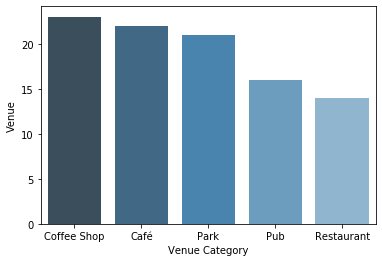

In [16]:
ottawa_short=ottawa_venues[['Venue Category','Venue']].groupby('Venue Category').nunique().drop(columns=['Venue Category'])
ottawa_short_top=ottawa_short.sort_values(by=['Venue'], ascending=False)[0:5]
sns.barplot(x="Venue Category", y="Venue", data=ottawa_short_top.reset_index(), palette="Blues_d")

In [36]:
ottawa_venues_count = ottawa_venues.groupby('Neighborhood').count().reset_index()
ottawa_venues_count[['Neighborhood', 'Venue']]

,Neighborhood,Venue
0,Barrhaven,4
1,Bells Corners,6
2,Billings Bridge,20
3,Blackburn Hamlet,11
4,Britannia Bay,3
5,ByWard Market,100
6,Cardinal Creek,7
7,Carleton Heights,1
8,Carlington,7
9,Carlsbad Springs,1


### Cluster Neigborhoods using Kmeans Clustering

In [18]:
ottawa_one_hot = pd.get_dummies(ottawa_venues[['Venue Category']], prefix="", prefix_sep="") 

# add neighborhood column back to dataframe
ottawa_one_hot['Neighborhood'] = ottawa_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [ottawa_one_hot.columns[-1]] + list(ottawa_one_hot.columns[:-1])
ottawa_one_hot = ottawa_one_hot[fixed_columns]

ottawa_one_hot.head()

,Yoga Studio,Adult Boutique,Airport Terminal,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,...,Toy / Game Store,Track,Trail,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Winery
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
ottawa_one_hot.shape

(609, 177)

In [20]:
# Group rows by neighborhood and take the mean as frequency of occurrence of each cateogry.
ottawa_grouped = ottawa_one_hot.groupby('Neighborhood').mean().reset_index()
ottawa_grouped.head()

,Neighborhood,Yoga Studio,Adult Boutique,Airport Terminal,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,...,Toy / Game Store,Track,Trail,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Winery
0,Barrhaven,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Bells Corners,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Billings Bridge,0.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Blackburn Hamlet,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Britannia Bay,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
num_top_venues = 5

for hood in ottawa_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp=ottawa_grouped[ottawa_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Barrhaven----
                     venue  freq
0        Convenience Store  0.25
1  Health & Beauty Service  0.25
2                      Gym  0.25
3            Tattoo Parlor  0.25
4                   Museum  0.00


----Bells Corners----
                        venue  freq
0             Thai Restaurant  0.17
1  Construction & Landscaping  0.17
2        Fast Food Restaurant  0.17
3          Seafood Restaurant  0.17
4   Middle Eastern Restaurant  0.17


----Billings Bridge----
           venue  freq
0    Coffee Shop  0.15
1     Restaurant  0.10
2       Tea Room  0.05
3  Grocery Store  0.05
4  Luggage Store  0.05


----Blackburn Hamlet----
               venue  freq
0               Bank  0.09
1       Skating Rink  0.09
2     Discount Store  0.09
3           Pharmacy  0.09
4  Convenience Store  0.09


----Britannia Bay----
              venue  freq
0       Curling Ice  0.33
1   Harbor / Marina  0.33
2  Insurance Office  0.33
3       Yoga Studio  0.00
4            Museum  0.00


----ByWar

In [22]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [23]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] =ottawa_grouped['Neighborhood']

for ind in np.arange(ottawa_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(ottawa_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Barrhaven,Convenience Store,Health & Beauty Service,Gym,Tattoo Parlor,Dive Bar,Fast Food Restaurant,Farmers Market,Electronics Store,Eastern European Restaurant,Dumpling Restaurant
1,Bells Corners,Middle Eastern Restaurant,Thai Restaurant,Fast Food Restaurant,Seafood Restaurant,Sandwich Place,Construction & Landscaping,Curling Ice,Deli / Bodega,Cosmetics Shop,Farmers Market
2,Billings Bridge,Coffee Shop,Restaurant,Grocery Store,Supermarket,Pet Store,Luggage Store,Pizza Place,Lingerie Store,Sandwich Place,Breakfast Spot
3,Blackburn Hamlet,Coffee Shop,Gas Station,Pharmacy,Chinese Restaurant,Pub,Discount Store,Sandwich Place,Skating Rink,Supermarket,Bank
4,Britannia Bay,Harbor / Marina,Curling Ice,Insurance Office,Winery,Dive Bar,Flea Market,Fast Food Restaurant,Farmers Market,Electronics Store,Eastern European Restaurant
5,ByWard Market,Coffee Shop,Restaurant,New American Restaurant,Dessert Shop,Hotel,Ice Cream Shop,Vietnamese Restaurant,Pub,Burger Joint,BBQ Joint
6,Cardinal Creek,Electronics Store,College Cafeteria,Food Service,Pharmacy,Juice Bar,Theater,Winery,Dive Bar,Farmers Market,Eastern European Restaurant
7,Carleton Heights,Farmers Market,Winery,Wine Shop,Flower Shop,Flea Market,Fast Food Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop
8,Carlington,Convenience Store,Italian Restaurant,Park,Vietnamese Restaurant,Laundromat,Pizza Place,Farmers Market,Electronics Store,Eastern European Restaurant,Dumpling Restaurant
9,Carlsbad Springs,Italian Restaurant,Food & Drink Shop,Flea Market,Fast Food Restaurant,Farmers Market,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Dog Run


In [24]:
# set number of clusters
kclusters = 4

ottawa_grouped_clustering = ottawa_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(ottawa_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[:] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 3, 0, 0,
       0, 0, 0, 3, 0, 0, 0, 0, 3, 2, 3, 3, 3, 0, 0, 3, 0, 0, 0, 0],
      dtype=int32)

In [25]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

ottawa_merged = ottawa_neighborhood

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
ottawa_merged = ottawa_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

ottawa_merged.head() # check the last columns!
ottawa_merged = ottawa_merged.dropna()

In [26]:
# create map
map_clusters = folium.Map(location=[latitude_ottawa, longitude_ottawa], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(ottawa_merged['Latitude'], ottawa_merged['Longitude'], ottawa_merged['Neighborhood'], ottawa_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters


### Filter the 4 cluster we created to understand which cluster have the most and heavy activites

In [27]:
ottawa_merged.loc[ottawa_merged['Cluster Labels'] == 0, ottawa_merged.columns[[0] + list(range(4, ottawa_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Orléans,Concert Hall,Movie Theater,Sporting Goods Shop,Sandwich Place,French Restaurant,Gas Station,Irish Pub,Bookstore,Gym,Grocery Store
1,Downtown,Coffee Shop,Bar,Taco Place,Restaurant,American Restaurant,Arts & Crafts Store,Bubble Tea Shop,Burger Joint,Café,Cantonese Restaurant
2,Barrhaven,Convenience Store,Health & Beauty Service,Gym,Tattoo Parlor,Dive Bar,Fast Food Restaurant,Farmers Market,Electronics Store,Eastern European Restaurant,Dumpling Restaurant
3,ByWard Market,Coffee Shop,Restaurant,New American Restaurant,Dessert Shop,Hotel,Ice Cream Shop,Vietnamese Restaurant,Pub,Burger Joint,BBQ Joint
4,Stittsville,Winery,Playground,Lake,Gastropub,Spa,Cupcake Shop,Donut Shop,Flea Market,Fast Food Restaurant,Farmers Market
6,Westboro,Yoga Studio,Coffee Shop,Restaurant,Pharmacy,Italian Restaurant,Sporting Goods Shop,Tapas Restaurant,Pub,Gym,Bank
7,The Glebe,Café,Pub,Coffee Shop,Japanese Restaurant,Park,Thai Restaurant,Indian Restaurant,Pizza Place,Italian Restaurant,Restaurant
10,Centretown,Coffee Shop,Yoga Studio,Gastropub,Café,Italian Restaurant,Seafood Restaurant,Tapas Restaurant,Bookstore,American Restaurant,Greek Restaurant
12,Billings Bridge,Coffee Shop,Restaurant,Grocery Store,Supermarket,Pet Store,Luggage Store,Pizza Place,Lingerie Store,Sandwich Place,Breakfast Spot
13,LeBreton Flats,Park,Music Venue,History Museum,Light Rail Station,Bus Station,Memorial Site,Rock Climbing Spot,Pub,Deli / Bodega,Dessert Shop


In [28]:
ottawa_merged.loc[ottawa_merged['Cluster Labels'] == 1, ottawa_merged.columns[[0] + list(range(4, ottawa_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,Constance Bay,Burger Joint,Winery,Convenience Store,Flower Shop,Flea Market,Fast Food Restaurant,Farmers Market,Electronics Store,Eastern European Restaurant,Dumpling Restaurant


In [29]:
ottawa_merged.loc[ottawa_merged['Cluster Labels'] == 2, ottawa_merged.columns[[0] + list(range(4, ottawa_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
31,Pineview,Fast Food Restaurant,Winery,Wine Shop,Flower Shop,Flea Market,Farmers Market,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop


In [30]:
ottawa_merged.loc[ottawa_merged['Cluster Labels'] == 3, ottawa_merged.columns[[0] + list(range(4, ottawa_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Skyline,Park,Historic Site,Flea Market,Fast Food Restaurant,Farmers Market,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Dog Run
21,Riverside South,Park,Trail,Convenience Store,Pharmacy,Yoga Studio,Antique Shop,Dive Bar,Flea Market,Fast Food Restaurant,Farmers Market
30,Kanata Lakes - M...,Park,Golf Course,Moving Target,Costume Shop,Dive Bar,Fast Food Restaurant,Farmers Market,Electronics Store,Eastern European Restaurant,Dumpling Restaurant
36,Overbrook,Park,Grocery Store,Pizza Place,Discount Store,Fast Food Restaurant,Farmers Market,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop
37,Riverview Park,Park,Pool,Dog Run,Discount Store,Fast Food Restaurant,Farmers Market,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop
42,Morgan's Grant,Park,Gym / Fitness Center,Playground,Discount Store,Fast Food Restaurant,Farmers Market,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop
44,Queenswood Heights,Park,Home Service,Bus Stop,Dive Bar,Flea Market,Fast Food Restaurant,Farmers Market,Electronics Store,Eastern European Restaurant,Dumpling Restaurant
